<a href="https://colab.research.google.com/github/edugalt/scaling/blob/master/notebooks/Notebook-SpatialModels-Colab.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Spatial Models for Urban Scaling Laws

<i>Spatial interactions in urban scaling laws </i>,
<a href="http://www.maths.usyd.edu.au/u/ega/"> Eduardo G. Altmann</a> <i>, <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0243390"> PLOS ONE 15, e0243390 (2020) </a>.

# Loading files to Colab

In [1]:
!git clone https://github.com/edugalt/scaling

Cloning into 'scaling'...
remote: Enumerating objects: 908, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 908 (delta 6), reused 0 (delta 0), pack-reused 893
Receiving objects: 100% (908/908), 136.19 MiB | 14.99 MiB/s, done.
Resolving deltas: 100% (272/272), done.
Updating files: 100% (734/734), done.


In [2]:
cd /content/scaling/notebooks/

/content/scaling/notebooks


In [3]:
import sys
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats
from scipy import optimize
import numpy as np

sys.path.append("/content/scaling/src/")
sys.path.append("/content/scaling/data/")

from spatial import *

%matplotlib inline
plt.rcParams.update({'font.size': 20})


import warnings
warnings.filterwarnings('ignore')


# Import data 

The data corresponds to 4 arrays with:

- $x$: the population of the urban areas
- $y$: the observable of interest in each urban area
- $l$: the location [latitude,longitude] of each urban area
- names: the name of the urban areas

To analyze your data you should import x,y,l as arrays and proceed as below



In [4]:
#Choose data
#country="Brazil";data="gdp";
#country="Brazil";data="external";
#country="Brazil";data="aids";
#country="USA";data="roads";
country="USA";data="gdp";

#Import data
d=getData(country,data);x,y,l,names=d[0],d[1],d[2],d[3];

#Compute the 
dmat = dmatrix(l);

# Models

Goal is to test scaling law:

$$ y \sim x^\beta$$

## Non-spatial Models

### Least square fitting

Exponent beta of least square fitting (removing zeros)

In [6]:
betaOLS,alphaOLS=np.polyfit(np.log(x[y>0]),np.log(y[y>0]),1)
print(betaOLS)

1.1127588806209117


### Per capita model

In [7]:
amat=amatModel(dmat,"percapita")   # Traditional model
L_percapita=minus_log_likelihood_beta(1,x,y,amat)
beta_percapita=1
print(beta_percapita,L_percapita)

1 71068060.10573398


### City model

In [8]:
amat=amatModel(dmat,"city")   # Traditional model
res2=optimize.minimize_scalar(
    fun=minus_log_likelihood_beta,
    args=(x,y,amat)
)
res2
L_no=res2.fun
beta_no=res2.x
L_city=L_no
beta_city=beta_no
print(beta_city,L_city)

1.1210314431264368 70846201.94868006


## Scaling Plots

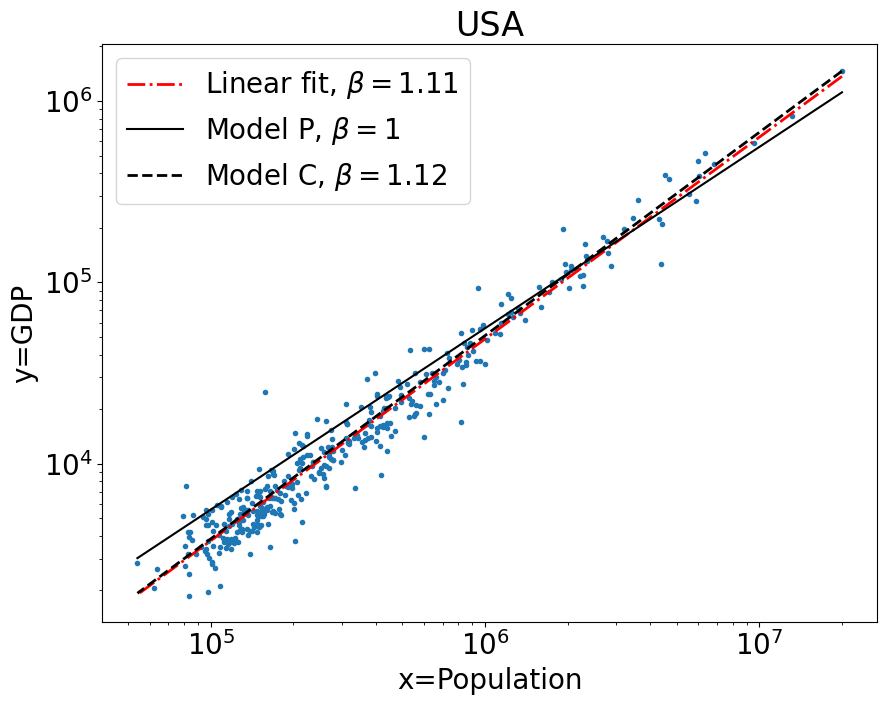

In [9]:
import string as s
Y=np.sum(y)
X=np.sum(x)
Xbeta=np.sum(x**beta_city)
plt.figure(figsize=[10,7.5])


plt.plot(x,y,".")
plt.plot(x,np.exp(betaOLS*np.log(x)+alphaOLS),"-.",lw=2,color="red",label=r"Linear fit, $\beta=$"+str(betaOLS)[:4])
plt.plot(x,Y*x/X,"-",color="black",label=r"Model P, $\beta=1$")
plt.plot(x,Y*x**beta_city/Xbeta,"--",color="black",lw=2,label=r"Model C, $\beta=$"+str(beta_city)[:4])
plt.loglog()
plt.title(country)
plt.xlabel("x=Population")
plt.ylabel("y="+data.upper())
plt.legend()
plt.show()

# Spatial models

## There are four models to choose from

In [10]:
models=["percapita","city","gravitational","exponential"]

## Varying  alpha in a range and computing the ML beta

In [11]:
alpharange=[1,2,5,7,10,15,20,30,50,75,100,120,150,200,300,500,750,1000]#,1200,1500]

Y = np.sum(y)
# First two terms of the log-likelihood
terms12 = Y*np.log(Y)-Y-np.sum(y[y>0]*np.log(y[y>0])-y[y>0])


# Gravitational model
model=models[2]
print("\n Model:\t"+model+"\nalpha,beta,-logL")
res_betasG=[];res_LG=[];resultsG=[];res_trueLogLG=[]
for alpha in alpharange:
    amat=amatModel(dmat,model,alpha) #Choosing the model
    res2=optimize.minimize_scalar(fun=minus_log_likelihood_beta,args=(x,y,amat),method="bounded",bounds=[0,2])
    res_betasG.append(res2.x),res_LG.append(res2.fun),resultsG.append(res2)
    res_trueLogLG.append(terms12-res2.fun)
    #res_trueLogLG.append(-res2.fun)
    print(alpha,res2.x,res2.fun)

alpha_bestG = alpharange[res_LG.index(min(res_LG))]
beta_bestG = res_betasG[res_LG.index(min(res_LG))]
print("Best alpha found is=",alpha_bestG," with -log(L)=",min(res_LG), "leading to beta=",beta_bestG,"\nto be compared with null L=",L_no," at beta=",beta_no)

# Exponential model
model=models[3]
print("\n Model:\t"+model+"\nalpha,beta,-logL")
res_betasE=[];res_LE=[];resultsE=[];res_trueLogLE=[]
for alpha in alpharange:
    amat=amatModel(dmat,model,alpha) #Choosing the model
    res2=optimize.minimize_scalar(fun=minus_log_likelihood_beta,args=(x,y,amat),method="bounded",bounds=[0,2])
    res_betasE.append(res2.x),res_LE.append(res2.fun),resultsE.append(res2)
    res_trueLogLE.append(terms12-res2.fun)
    print(alpha,res2.x,res2.fun)

alpha_bestE = alpharange[res_LE.index(min(res_LE))]
beta_bestE = res_betasE[res_LE.index(min(res_LE))]
print("Best alpha found is=",alpha_bestE," with -log(L)=",min(res_LE), "leading to beta=",beta_bestE,"\nto be compared with null L=",L_no," at beta=",beta_no)
    


 Model:	gravitational
alpha,beta,-logL
1 1.1210970965825549 70846209.06530373
2 1.1212912282163348 70846231.5549433
5 1.1225592587657327 70846428.07695732
7 1.123860084621207 70846713.6867691
10 1.1262661066725919 70847452.05870798
15 1.130953139941045 70849611.92011906
20 1.1359225806263153 70852879.02943684
30 1.1454905102991988 70861894.89892134
50 1.1606880508848119 70884388.78429557
75 1.1719600323985686 70912636.00902545
100 1.1765365887672332 70937410.26379147
120 1.176801115943065 70954320.19852968
150 1.1735573927526843 70975222.57619634
200 1.1632792922573745 71000526.25674877
300 1.1396843620924912 71029136.55721292
500 1.104945080915058 71051271.96536432
750 1.0797864315870351 71060438.35380423
1000 1.0636952905502304 71064151.1480022
Best alpha found is= 1  with -log(L)= 70846209.06530373 leading to beta= 1.1210970965825549 
to be compared with null L= 70846201.94868006  at beta= 1.1210314431264368

 Model:	exponential
alpha,beta,-logL
1 1.1210315235566333 70846201.948509

# Plots

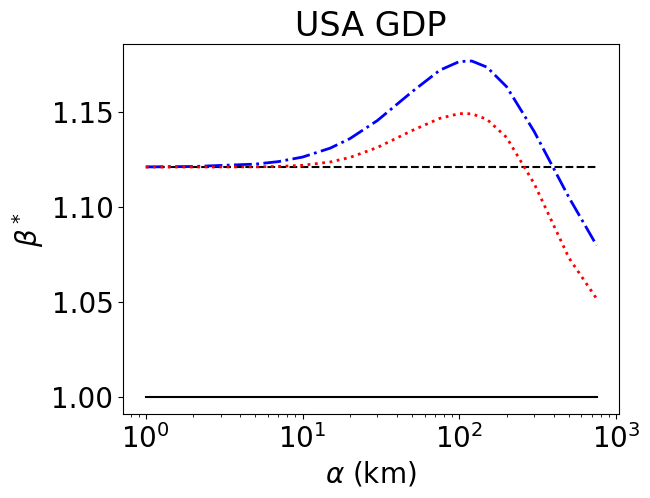

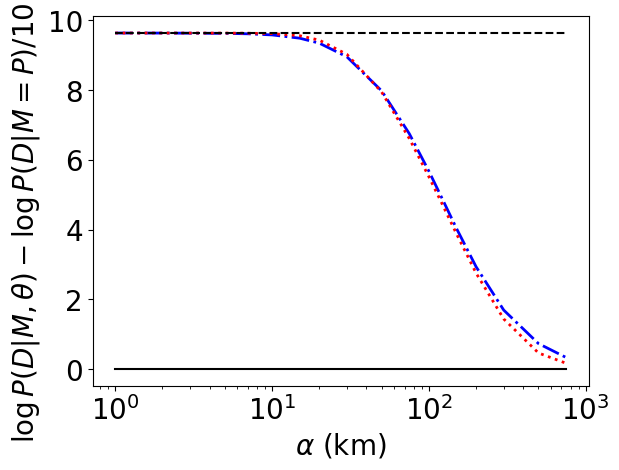

In [12]:
#font = {'family' : 'normal', 'weight' : 'normal',    'size'   : 15}

#plt.matplotlib.rc('font', **font)


logL_percapita=terms12-L_percapita
logL_city=terms12-L_city
amax=len(alpharange)-1
s=4
scale=10**s*np.log(10) #change to base 10

plt.figure()
plt.title(country+" "+data.upper())

plt.xscale("log")
plt.plot([alpharange[0],alpharange[amax-1]],[1.0,1.0],"-",color="black",label="Model P")
plt.plot([alpharange[0],alpharange[amax-1]],[beta_no,beta_no],"--",color="black",label="Model C")
plt.plot(alpharange[:amax], res_betasG[:amax],"-.",ms=5,lw=2, color="blue", label="Model G")
plt.plot(alpharange[:amax], res_betasE[:amax],":",ms=5,lw=2, color="red", label="Model E")
plt.xlabel(r"$\alpha$ (km)")
plt.ylabel(r"$\beta^*$")
#plt.legend(loc="lower left")
plt.show()

plt.figure()
plt.xscale("log")
plt.yscale("linear")
plt.plot(alpharange[:amax], (res_trueLogLG-logL_percapita)[:amax]/scale,"-.",ms=5, lw=2,color="blue")
plt.plot(alpharange[:amax], (res_trueLogLE-logL_percapita)[:amax]/scale,":",ms=5, lw=2,color="red")
plt.plot([alpharange[0],alpharange[amax-1]],[0,0],"-",color="black")
plt.plot([alpharange[0],alpharange[amax-1]],[(logL_city-logL_percapita)/scale,(logL_city-logL_percapita)/scale],"--",color="black")
plt.xlabel(r"$\alpha$ (km)")
plt.ylabel(r"$\log P(D|M,\theta) - \log P(D|M=P)/10$^"+str(s))
#legend(loc="lower right")
plt.show()


# Maximum Likelihood estimations for the chosen data and model

In [13]:
for mdl in ["percapita","city","gravitational","exponential"]:
    mlpar = MLparameters(x,y,l,mdl)
    print(mdl,"(alpha,beta,-logL)= ",mlpar)

percapita (alpha,beta,-logL)=  (0, 1, 71068060.10573398)
city (alpha,beta,-logL)=  (0, 1.1210315232928587, 70846201.94868016)
gravitational (alpha,beta,-logL)=  (3.3653546053240206e-06, 1.1210315232928507, 70846201.94868018)
exponential (alpha,beta,-logL)=  (1.653159153787639, 1.1210316400864295, 70846201.93732426)


In [14]:
model=models[1]
alphaML,betaML,logLML= MLparameters(x,y,l,model)

# Uncertainty in $\beta$ computed using bootstrapping

In [15]:
def surrogate(x,y):
    "Return (x_s,y_s) by sampling with replacement (x,y) the same number of elements of (x,y)"
    x_s=[];y_s=[];
    N=len(x);
    r=[np.random.randint(0,N) for i in range(N)] #N random numbers in [0,N)
    r.sort()
    x_s=[x[i] for i in r]
    y_s=[y[i] for i in r]
    return x_s,y_s

S=10 # number of surrogates
betas={}
for mdl in ["city","gravitational","exponential"]:
    betas[mdl]=[]
for s in range(S):
    xs,ys=surrogate(x,y)
    for mdl in ["city","gravitational","exponential"]:
        mlpar = MLparameters(xs,ys,l,mdl)
        betas[mdl].append(mlpar[1])
    print("Surrogate ",str(s)," out of ",str(S))
    
print(country,data,"\n","\t <beta>, \t sigma_beta")
for mdl in ["city","gravitational","exponential"]:
    print(mdl,np.average(betas[mdl]),np.std(betas[mdl]))

Surrogate  0  out of  10
Surrogate  1  out of  10
Surrogate  2  out of  10
Surrogate  3  out of  10
Surrogate  4  out of  10
Surrogate  5  out of  10
Surrogate  6  out of  10
Surrogate  7  out of  10
Surrogate  8  out of  10
Surrogate  9  out of  10
USA gdp 
 	 <beta>, 	 sigma_beta
city 1.1182002857103515 0.007831861021220465
gravitational 1.1207212083493574 0.009571443330694445
exponential 1.1183255996636832 0.007794500840298235


# Description Length estimations

The descripton length is:

$\mathcal{D}= -\log(P(D,M)) = -\log(\int d\theta P(D,M,\theta)) = - \log(\int d\theta P(D|M,\theta))-\log(P(M)) - \log(P(\theta|M))$

The log- likelihood can be written as a sum of two constant terms $T_{12}$ and the third relevant term $T_3$

$\log(\int d\theta P(D|M,\theta)) = \log \int d\theta e^{T_{12}+T_3} = T_{12}+\log \int d\theta e^{T3}$

For numerical convenience, we compute in the function integraedL the quantity $I$, obtained subtracting T3 at the maximum likelihood parameters, called logLML in the code

$I= \int d\theta e^{T3-logLML}= e^{-logLML} \int d\theta e^{T3}$

so that 

$\log I = -logLML + \log \int d\theta e^T3$

The description length is thus computed in function DL as:

$D= - priors - T_{12} -\log I - logLML $

where $priors = - \log(P(M)) -\log(P(\theta|M))$ 

## Computing I

The value of I is obtained integrating the loglikelihood close to the maximum likelihood parameters

We need to choose carefully the range around the maximum in which the integration is performed, otherwise the numerical integration may fail or take a long time

In [16]:
amin=max(-alphaML,-2) #minimum alpha should be larger than 0
amax=min(6371-alphaML,2) # maximum alpha shoulbe smaller than the earth's radius

bmin=max(-betaML,-0.025) #the minimum beta should be larger than 0
bmax=min(2-betaML,0.025) #the maximum beta should be smaller than 2

eps=10**(-6) # precision of integration method

If the model is the Per-capita model, there is nothing to be computed (no parameter)

If the model is the city model, we need to integrate over $\beta$ only, otherwise over $\alpha$ and $\beta$

Warning: These computations may take a long time.

In [17]:
model="city"

neglogLML = -logLML

if model=="city":
    #integrate over beta only
    gbeta = lambda be: np.exp(log_likelihood_alphabeta(alphaML,betaML+be,x,y,l,model)-neglogLML)
    I=sp.integrate.quad(gbeta,bmin,bmax,epsrel=eps)[0]
    
    
if model=="gravitational" or model=="exponential":
    #integrate over alpha and beta; first term of par is the variation in alpha, second is the variation in beta, third is precision
    g2 =  lambda ae,be: np.exp(log_likelihood_alphabeta(alphaML+ae,betaML+be,x,y,l,model)-neglogLML)
    I=sp.integrate.dblquad(g2,bmin,bmax,lambda be:amin,lambda be:amax,epsrel=eps,epsabs=eps)[0]
print(I)

0.0004599346336921189


## Computing the Description length

In [18]:
T12=logLikelihood12(y)
prior=negLogPrior(model)
D=-1.*np.log(I)+logLML+T12+prior
print(D,"\n",-np.log(I),logLML,T12,prior)

141317451.5468824 
 7.684426179247697 70846201.94868016 70471239.83433452 2.0794415416798357


# Pre-computed results

The maximum likelihood estimations and the description length have been pre-computed for all datasets and models. It can be found in the file:

../results/inference.json


In [19]:
import json
f=open("../results/inference.json","r")
pre=json.load(f)
f.close()

In [20]:
pre[country][data]["C"]

{'alpha': 0,
 'beta': 1.1210314431264368,
 'logLML': 70846201.94868006,
 'terms12': 70471239.83433452,
 'aRange': 0,
 'bRange': 0.025,
 'BICFactor': 16.528874615490224,
 'prior': 2.0794415416798357,
 'logI': 7.6844262838044335,
 'D': 141317451.5468824,
 'Dbits': 203877986.5377536}

The entries correspond to:

- alpha,beta,logLML: the maximum likelihood values, ogLML is the third term of the log likelihood
- arange,brange: the range of parameters integrated to compute I (up to 10x these values were used)
- logI, obtained from the integration
- BIC factor, $-k \log(Y)$, to be compared with $\log I$
- prior, the negative log probability of the priors of this model
- D, the description legngth of the model
    

In [21]:
pre

{'Brazil': {'gdp': {'P': {'alpha': 0,
    'beta': 1,
    'logLML': 23660859827.903328,
    'terms12': 22652796641.57405,
    'aRange': 0,
    'bRange': 0,
    'BICFactor': 0,
    'prior': 1.3862943611198906,
    'logI': 0,
    'D': 46313656470.86367,
    'Dbits': 66816482515.95007},
   'C': {'alpha': 0,
    'beta': 1.1663314815354546,
    'logLML': 23420651424.189156,
    'terms12': 22652796641.57405,
    'aRange': 0,
    'bRange': 3e-05,
    'BICFactor': 22.0482738386467,
    'prior': 2.0794415416798357,
    'logI': 10.875019959406075,
    'D': 46073448078.717674,
    'Dbits': 66469935059.82113},
   'G': {'alpha': 14.599567066050234,
    'beta': 1.2364913508161357,
    'logLML': 23383750938.948578,
    'terms12': 22652796641.57405,
    'aRange': 0.01,
    'bRange': 4e-05,
    'BICFactor': 44.0965476772934,
    'prior': 10.838953263796325,
    'logI': 15.574536503602513,
    'D': 46036547606.93612,
    'Dbits': 66416698932.175415},
   'E': {'alpha': 17.560444058754186,
    'beta': 1.21